In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
DEVICE

device(type='cuda')

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=0.2),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

## Image processing and Class visualization

In [11]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.image_paths = []
        self.labels = []
        
        # Load data
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [12]:
def get_data_loaders(data_path):
    train_dataset = ChestXrayDataset(os.path.join(data_path, 'train'), 
                                   train_transform)
    val_dataset = ChestXrayDataset(os.path.join(data_path, 'val'), 
                                 test_transform)
    test_dataset = ChestXrayDataset(os.path.join(data_path, 'test'), 
                                  test_transform)
    
    print("Training samples:", len(train_dataset))
    print("Validation samples:", len(val_dataset))
    print("Test samples:", len(test_dataset))
    train_len = len(train_dataset)
    test_len = len(test_dataset)
    val_len = len(val_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                            shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                          shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                           shuffle=False, num_workers=4)
    
    return train_loader, val_loader, test_loader, train_len, val_len, test_len

In [13]:
data_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_loader, val_loader, test_loader, train_len, val_len, test_len = get_data_loaders(data_path)

Training samples: 5216
Validation samples: 16
Test samples: 624


In [29]:
classes = ["NORMAL", "PNEUMONIA"]

In [30]:
stats = {'train': {}, 'val': {}, 'test': {}}
        
for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_path, split)
    for class_name in classes:
        class_path = os.path.join(split_path, class_name)
        num_images = len(os.listdir(class_path))
        stats[split][class_name] = num_images

# Create a DataFrame for better visualization
df_stats = pd.DataFrame(stats).T
df_stats

NORMAL  PNEUMONIA
train    1341       3875
val         8          8
test      234        390

<Figure size 1200x600 with 0 Axes>

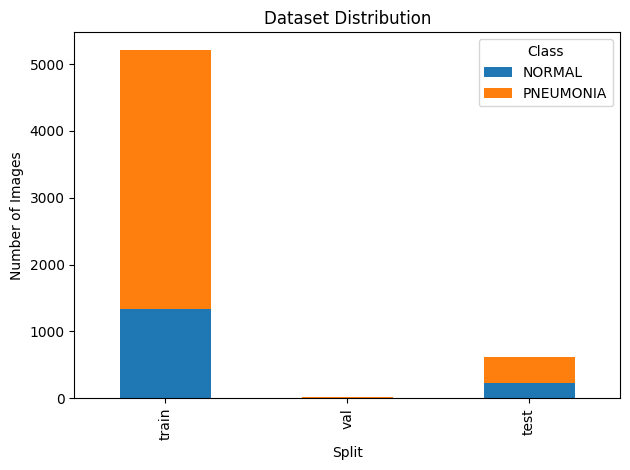

In [31]:
plt.figure(figsize=(12, 6))
df_stats.plot(kind='bar', stacked=True)
plt.title('Dataset Distribution')
plt.xlabel('Split')
plt.ylabel('Number of Images')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

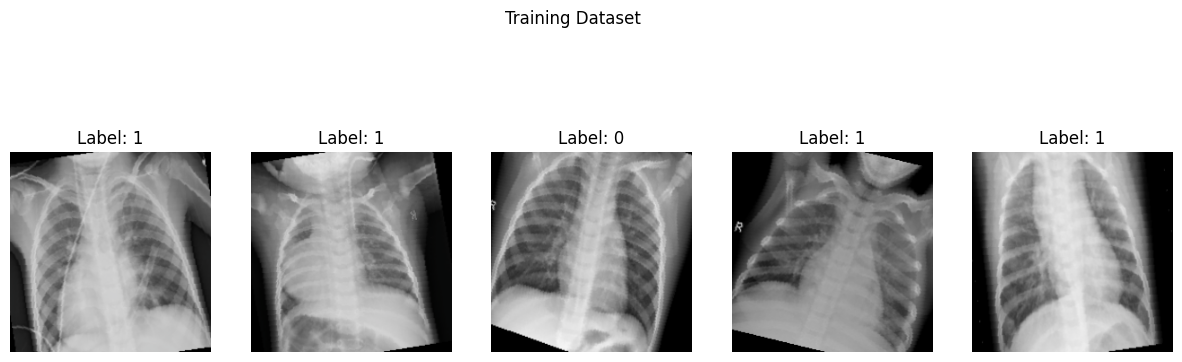

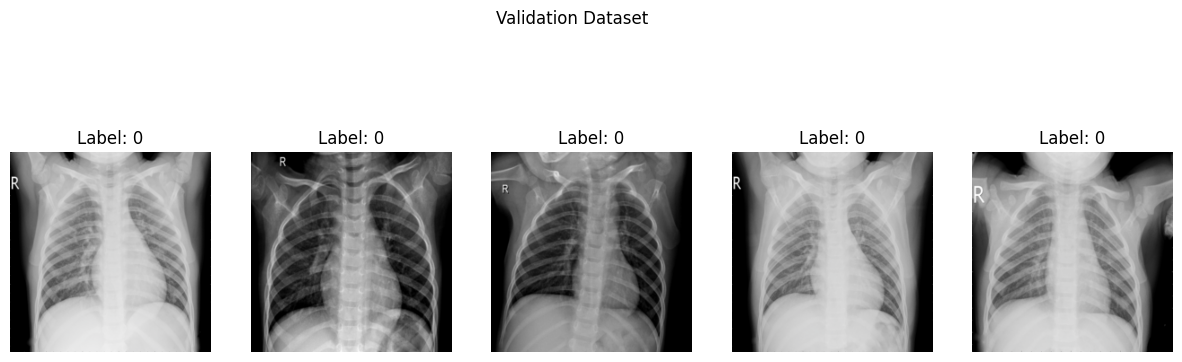

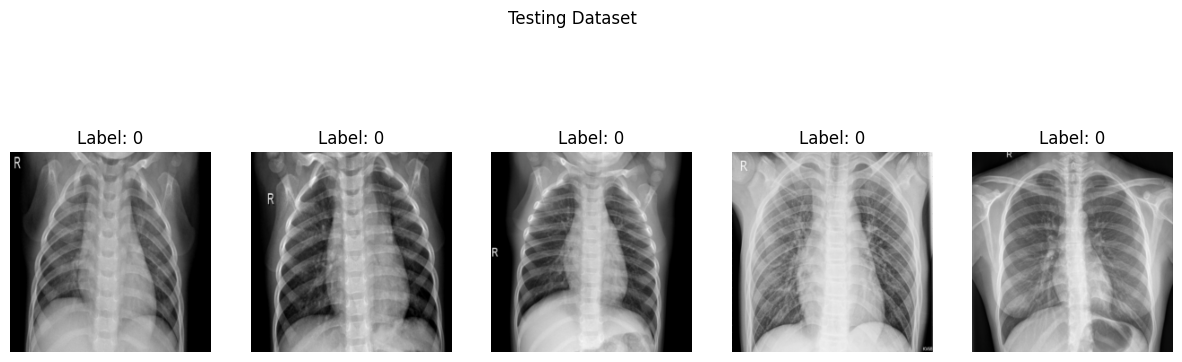

In [32]:
def show_images(loader, title):
    images, labels = next(iter(loader))
    images = images[:5]  # Show first 5 images
    labels = labels[:5]
    
    plt.figure(figsize=(15, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show images from training, validation, and testing datasets
show_images(train_loader, 'Training Dataset')
show_images(val_loader, 'Validation Dataset')
show_images(test_loader, 'Testing Dataset')

## Model 1 : ResNet Model

In [33]:
class ResNetModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.resnet(x))

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, writer):
    best_val_loss = float('inf')
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'per_epoch_stats': [],
        'best_epoch': 0,
        'best_val_loss': float('inf'),
        'best_val_accuracy': 0.0
    }
    
    for epoch in range(num_epochs):
        epoch_stats = {'epoch': epoch + 1}
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        # Store training metrics
        metrics['train_losses'].append(epoch_loss)
        metrics['train_accuracies'].append(epoch_acc)
        epoch_stats.update({
            'train_loss': epoch_loss,
            'train_accuracy': epoch_acc,
            'train_correct': correct,
            'train_total': total
        })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_true_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Store predictions and true labels for metrics
                val_predictions.extend(predicted.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        
        # Store validation metrics
        metrics['val_losses'].append(val_epoch_loss)
        metrics['val_accuracies'].append(val_epoch_acc)
        epoch_stats.update({
            'val_loss': val_epoch_loss,
            'val_accuracy': val_epoch_acc,
            'val_correct': val_correct,
            'val_total': val_total
        })
        
        # Calculate additional metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        precision = precision_score(val_true_labels, val_predictions, zero_division=0)
        recall = recall_score(val_true_labels, val_predictions, zero_division=0)
        f1 = f1_score(val_true_labels, val_predictions, zero_division=0)
        
        epoch_stats.update({
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
        
        # Store complete epoch stats
        metrics['per_epoch_stats'].append(epoch_stats)
        
        # TensorBoard logging
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/val', val_epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        writer.add_scalar('Accuracy/val', val_epoch_acc, epoch)
        writer.add_scalar('Metrics/precision', precision, epoch)
        writer.add_scalar('Metrics/recall', recall, epoch)
        writer.add_scalar('Metrics/f1_score', f1, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        
        # Save best model and update best metrics
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            metrics['best_epoch'] = epoch + 1
            metrics['best_val_loss'] = val_epoch_loss
            metrics['best_val_accuracy'] = val_epoch_acc
            
            # Save model and metrics
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_epoch_loss,
                'val_accuracy': val_epoch_acc,
                'metrics': metrics
            }, 'best_model.pth')
            
            # Save metrics separately for easy access
            import json
            with open('training_metrics.json', 'w') as f:
                json.dump(metrics, f, indent=4)
    
    # Calculate and store final statistics
    metrics['final_stats'] = {
        'final_train_loss': metrics['train_losses'][-1],
        'final_train_accuracy': metrics['train_accuracies'][-1],
        'final_val_loss': metrics['val_losses'][-1],
        'final_val_accuracy': metrics['val_accuracies'][-1],
        'best_epoch': metrics['best_epoch'],
        'best_val_loss': metrics['best_val_loss'],
        'best_val_accuracy': metrics['best_val_accuracy']
    }
    
    return metrics

In [35]:
writer = SummaryWriter('runs/pneumonia_experiment')

# Load data
# Initialize models
resnet_model = ResNetModel().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Train and evaluate ResNet model
print("Training ResNet model...")
metrics_resnet = train_model(resnet_model, train_loader, 
                                        val_loader, criterion, optimizer, 
                                        EPOCHS, writer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Training ResNet model...


Epoch 1/20: 100%|██████████| 163/163 [01:03<00:00,  2.56it/s]


Epoch 1/20:
Train Loss: 0.2386, Train Acc: 89.74%
Val Loss: 3.1617, Val Acc: 50.00%
Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 2/20: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]


Epoch 2/20:
Train Loss: 0.1700, Train Acc: 93.27%
Val Loss: 0.5176, Val Acc: 81.25%
Precision: 0.7273, Recall: 1.0000, F1: 0.8421


Epoch 3/20: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]


Epoch 3/20:
Train Loss: 0.1443, Train Acc: 94.23%
Val Loss: 0.3788, Val Acc: 87.50%
Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 4/20: 100%|██████████| 163/163 [01:02<00:00,  2.63it/s]


Epoch 4/20:
Train Loss: 0.1518, Train Acc: 94.52%
Val Loss: 0.5719, Val Acc: 75.00%
Precision: 0.6667, Recall: 1.0000, F1: 0.8000


Epoch 5/20: 100%|██████████| 163/163 [01:02<00:00,  2.63it/s]


Epoch 5/20:
Train Loss: 0.1291, Train Acc: 95.40%
Val Loss: 0.4883, Val Acc: 75.00%
Precision: 0.6667, Recall: 1.0000, F1: 0.8000


Epoch 6/20: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]


Epoch 6/20:
Train Loss: 0.1347, Train Acc: 95.25%
Val Loss: 0.4554, Val Acc: 81.25%
Precision: 0.8571, Recall: 0.7500, F1: 0.8000


Epoch 7/20: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]


Epoch 7/20:
Train Loss: 0.1177, Train Acc: 95.55%
Val Loss: 0.7049, Val Acc: 75.00%
Precision: 0.7000, Recall: 0.8750, F1: 0.7778


Epoch 8/20: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]


Epoch 8/20:
Train Loss: 0.1153, Train Acc: 95.99%
Val Loss: 0.5137, Val Acc: 87.50%
Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 9/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Epoch 9/20:
Train Loss: 0.1064, Train Acc: 96.05%
Val Loss: 0.5206, Val Acc: 75.00%
Precision: 0.6667, Recall: 1.0000, F1: 0.8000


Epoch 10/20: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]


Epoch 10/20:
Train Loss: 0.0955, Train Acc: 96.64%
Val Loss: 0.3459, Val Acc: 81.25%
Precision: 0.7273, Recall: 1.0000, F1: 0.8421


Epoch 11/20: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]


Epoch 11/20:
Train Loss: 0.1236, Train Acc: 95.63%
Val Loss: 0.3495, Val Acc: 87.50%
Precision: 1.0000, Recall: 0.7500, F1: 0.8571


Epoch 12/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Epoch 12/20:
Train Loss: 0.1062, Train Acc: 96.20%
Val Loss: 0.3688, Val Acc: 81.25%
Precision: 0.7273, Recall: 1.0000, F1: 0.8421


Epoch 13/20: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]


Epoch 13/20:
Train Loss: 0.1027, Train Acc: 96.53%
Val Loss: 0.8179, Val Acc: 68.75%
Precision: 0.6154, Recall: 1.0000, F1: 0.7619


Epoch 14/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Epoch 14/20:
Train Loss: 0.0982, Train Acc: 96.43%
Val Loss: 0.5134, Val Acc: 75.00%
Precision: 0.6667, Recall: 1.0000, F1: 0.8000


Epoch 15/20: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]


Epoch 15/20:
Train Loss: 0.0983, Train Acc: 96.64%
Val Loss: 0.3060, Val Acc: 87.50%
Precision: 1.0000, Recall: 0.7500, F1: 0.8571


Epoch 16/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Epoch 16/20:
Train Loss: 0.0950, Train Acc: 96.72%
Val Loss: 0.2394, Val Acc: 93.75%
Precision: 1.0000, Recall: 0.8750, F1: 0.9333


Epoch 17/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Epoch 17/20:
Train Loss: 0.0866, Train Acc: 97.24%
Val Loss: 0.1460, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 18/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Epoch 18/20:
Train Loss: 0.0836, Train Acc: 97.03%
Val Loss: 0.4877, Val Acc: 75.00%
Precision: 0.7500, Recall: 0.7500, F1: 0.7500


Epoch 19/20: 100%|██████████| 163/163 [01:01<00:00,  2.66it/s]


Epoch 19/20:
Train Loss: 0.0880, Train Acc: 96.91%
Val Loss: 0.2830, Val Acc: 81.25%
Precision: 0.7778, Recall: 0.8750, F1: 0.8235


Epoch 20/20: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]


Epoch 20/20:
Train Loss: 0.0897, Train Acc: 96.70%
Val Loss: 0.2208, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [36]:
print("\nTraining Summary:")
print(f"Best Epoch: {metrics_resnet['best_epoch']}")
print(f"Best Validation Loss: {metrics_resnet['best_val_loss']:.4f}")
print(f"Best Validation Accuracy: {metrics_resnet['best_val_accuracy']:.2f}%")


Training Summary:
Best Epoch: 17
Best Validation Loss: 0.1460
Best Validation Accuracy: 100.00%


In [18]:
def plot_loss_acc(metrics):
    plt.figure(figsize=(15, 5))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracies'], label='Train Accuracy')
    plt.plot(metrics['val_accuracies'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Plot the training and testing accuracy and losses

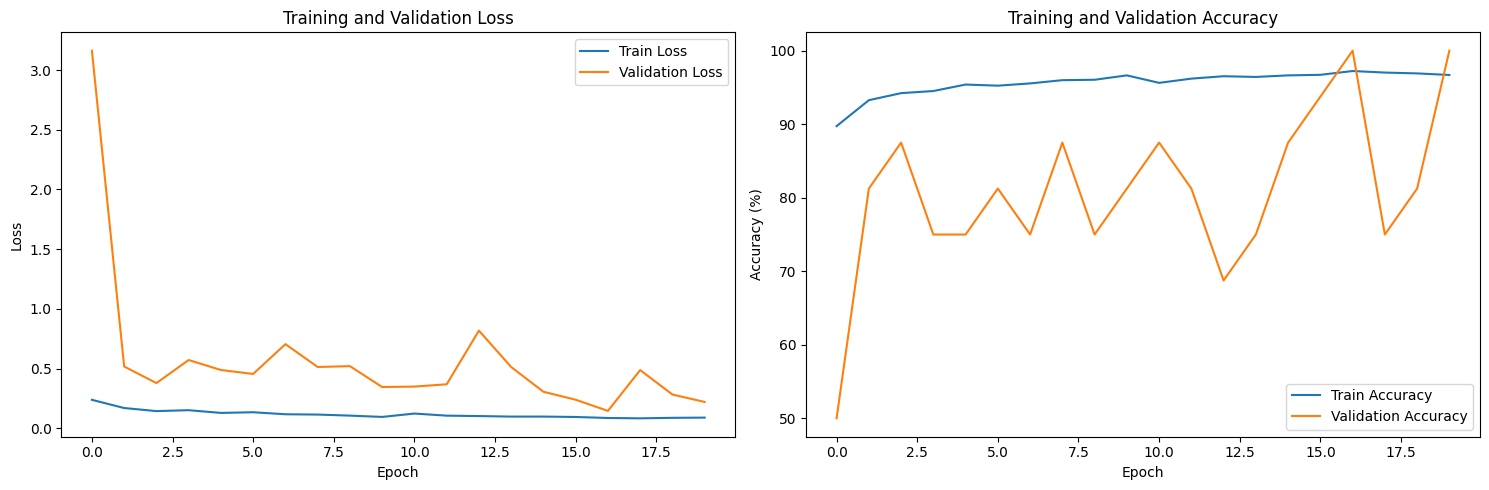

In [38]:
plot_loss_acc(metrics_resnet)


In [19]:
def plot_other_metrics(metrics): 
    plt.figure(figsize=(10, 5))
    epochs = range(1, 20 + 1)
    precisions = [stat['precision'] for stat in metrics['per_epoch_stats']]
    recalls = [stat['recall'] for stat in metrics['per_epoch_stats']]
    f1_scores = [stat['f1_score'] for stat in metrics['per_epoch_stats']]
    
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1_scores, label='F1 Score')
    plt.title('Training Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

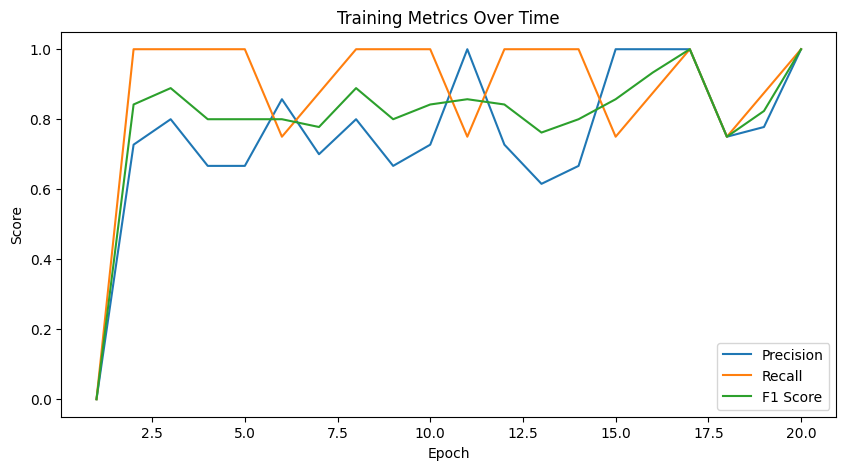

In [40]:
plot_other_metrics(metrics_resnet)

In [ ]:
def evaluate_trained_model(model_path, model, test_loader, device, writer):
    """
    Evaluate a trained model with comprehensive metrics and visualizations
    """
    # Load the best model checkpoint
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    training_metrics = checkpoint['metrics']
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize metrics
    test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    criterion = nn.BCELoss()
    
    # Evaluate model
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            # Calculate predictions
            predictions = (outputs > 0.5).float()
            
            # Accumulate metrics
            test_loss += loss.item() * inputs.size(0)
            test_correct += torch.sum(predictions == labels)
            test_total += labels.size(0)
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())
    
    # Calculate final metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * test_correct / test_total
    
    # Calculate additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Precision-Recall curve and AP
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probabilities)
    average_precision = average_precision_score(all_labels, all_probabilities)
    
    # Create evaluation metrics dictionary
    eval_metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy.item(),
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm.tolist(),
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        'training_history': training_metrics
    }
    
    # Print evaluation results
    print("\nTest Set Evaluation Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")
    
    import seaborn as sns
# Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(15, 5))

    import json
    with open('evaluation_metrics.json', 'w') as f:
        json.dump(eval_metrics, f, indent=4)
    
    # Log final metrics to TensorBoard
    writer.add_scalar('Test/Loss', test_loss)
    writer.add_scalar('Test/Accuracy', test_accuracy)
    writer.add_scalar('Test/Precision', precision)
    writer.add_scalar('Test/Recall', recall)
    writer.add_scalar('Test/F1', f1)
    writer.add_scalar('Test/ROC_AUC', roc_auc)
    writer.add_scalar('Test/Average_Precision', average_precision)
    
    writer.close()
    
    return eval_metrics


Evaluating best model...


<ipython-input-41-4ac8f29d7a0b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.73it


Test Set Evaluation Results:
Test Loss: 0.1976
Test Accuracy: 93.11%
Precision: 0.9348
Recall: 0.9564
F1 Score: 0.9455
ROC AUC: 0.9779
Average Precision: 0.9856


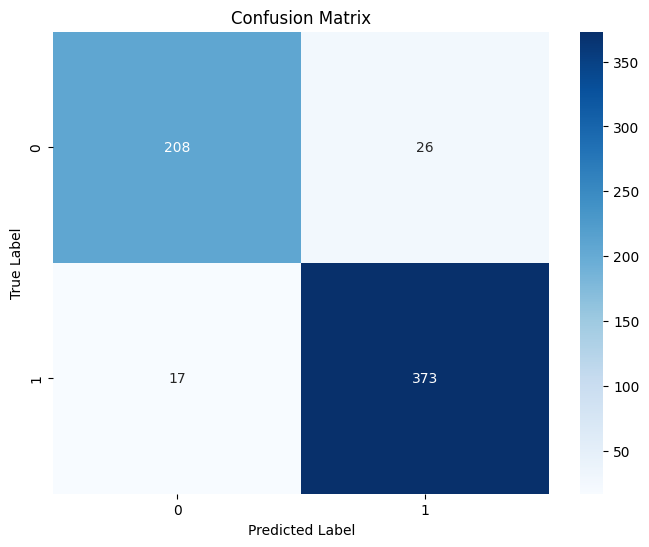

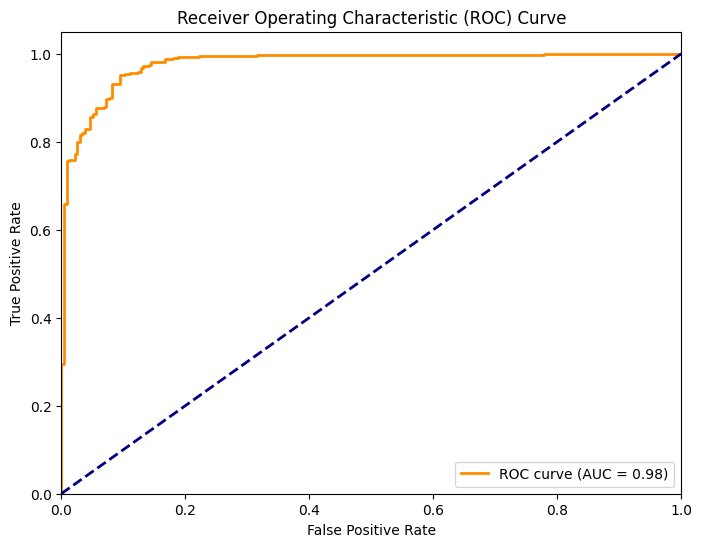

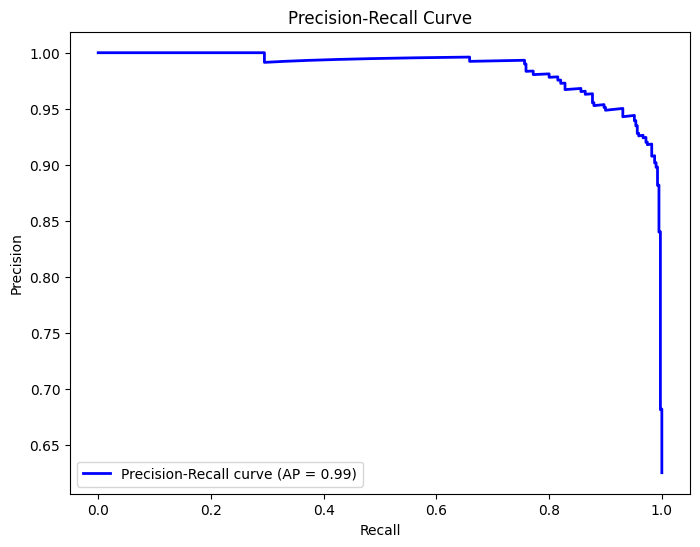

<Figure size 1500x500 with 0 Axes>

In [42]:
# Example usage:
print("\nEvaluating best model...")
eval_metrics = evaluate_trained_model(
    model_path='best_model.pth',
    model=resnet_model,
    test_loader=test_loader,
    device=DEVICE,
    writer=writer
)

In [43]:
# Access specific metrics if needed
print("\nTest Performance Summary:")
print(f"Final Test Accuracy: {eval_metrics['test_accuracy']:.2f}%")
print(f"ROC AUC Score: {eval_metrics['roc_auc']:.4f}")
print(f"Average Precision Score: {eval_metrics['average_precision']:.4f}")


Test Performance Summary:
Final Test Accuracy: 93.11%
ROC AUC Score: 0.9779
Average Precision Score: 0.9856


## Model 2 : DenseNet Model

In [14]:
class DenseNetModel(nn.Module):
    def __init__(self, pretrained=True):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=pretrained)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.densenet(x))

In [15]:
writer = SummaryWriter('runs/pneumonia_experiment')

In [21]:
densenet_model= DenseNetModel().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.0001)

print("Training DenseNet model...")
metrics_densenet = train_model(densenet_model, train_loader, 
                                        val_loader, criterion, optimizer, 
                                        EPOCHS, writer)

Training DenseNet model...


Epoch 1/20: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]


Epoch 1/20:
Train Loss: 0.1706, Train Acc: 93.31%
Val Loss: 0.2516, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 2/20: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 2/20:
Train Loss: 0.0763, Train Acc: 97.28%
Val Loss: 0.2226, Val Acc: 81.25%
Precision: 1.0000, Recall: 0.6250, F1: 0.7692


Epoch 3/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 3/20:
Train Loss: 0.0660, Train Acc: 97.68%
Val Loss: 0.1593, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 4/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 4/20:
Train Loss: 0.0544, Train Acc: 98.06%
Val Loss: 0.2043, Val Acc: 87.50%
Precision: 0.8000, Recall: 1.0000, F1: 0.8889


Epoch 5/20: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]


Epoch 5/20:
Train Loss: 0.0462, Train Acc: 98.35%
Val Loss: 0.0947, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 6/20: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]


Epoch 6/20:
Train Loss: 0.0403, Train Acc: 98.47%
Val Loss: 0.1739, Val Acc: 87.50%
Precision: 0.8750, Recall: 0.8750, F1: 0.8750


Epoch 7/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 7/20:
Train Loss: 0.0383, Train Acc: 98.72%
Val Loss: 0.1006, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 8/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 8/20:
Train Loss: 0.0333, Train Acc: 98.75%
Val Loss: 0.1412, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 9/20: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]


Epoch 9/20:
Train Loss: 0.0316, Train Acc: 98.89%
Val Loss: 0.2586, Val Acc: 81.25%
Precision: 0.7273, Recall: 1.0000, F1: 0.8421


Epoch 10/20: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


Epoch 10/20:
Train Loss: 0.0298, Train Acc: 98.96%
Val Loss: 0.1311, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 11/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 11/20:
Train Loss: 0.0311, Train Acc: 98.79%
Val Loss: 0.1691, Val Acc: 93.75%
Precision: 1.0000, Recall: 0.8750, F1: 0.9333


Epoch 12/20: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]


Epoch 12/20:
Train Loss: 0.0249, Train Acc: 99.02%
Val Loss: 0.1640, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 13/20: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


Epoch 13/20:
Train Loss: 0.0229, Train Acc: 99.31%
Val Loss: 0.0694, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 14/20: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]


Epoch 14/20:
Train Loss: 0.0243, Train Acc: 99.14%
Val Loss: 0.1549, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 15/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 15/20:
Train Loss: 0.0233, Train Acc: 99.18%
Val Loss: 0.1261, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 16/20: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


Epoch 16/20:
Train Loss: 0.0143, Train Acc: 99.48%
Val Loss: 0.0146, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 17/20: 100%|██████████| 163/163 [00:59<00:00,  2.72it/s]


Epoch 17/20:
Train Loss: 0.0083, Train Acc: 99.75%
Val Loss: 0.0158, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 18/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 18/20:
Train Loss: 0.0179, Train Acc: 99.21%
Val Loss: 0.0391, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 19/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


Epoch 19/20:
Train Loss: 0.0177, Train Acc: 99.31%
Val Loss: 0.0460, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 20/20: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Epoch 20/20:
Train Loss: 0.0139, Train Acc: 99.46%
Val Loss: 0.0233, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


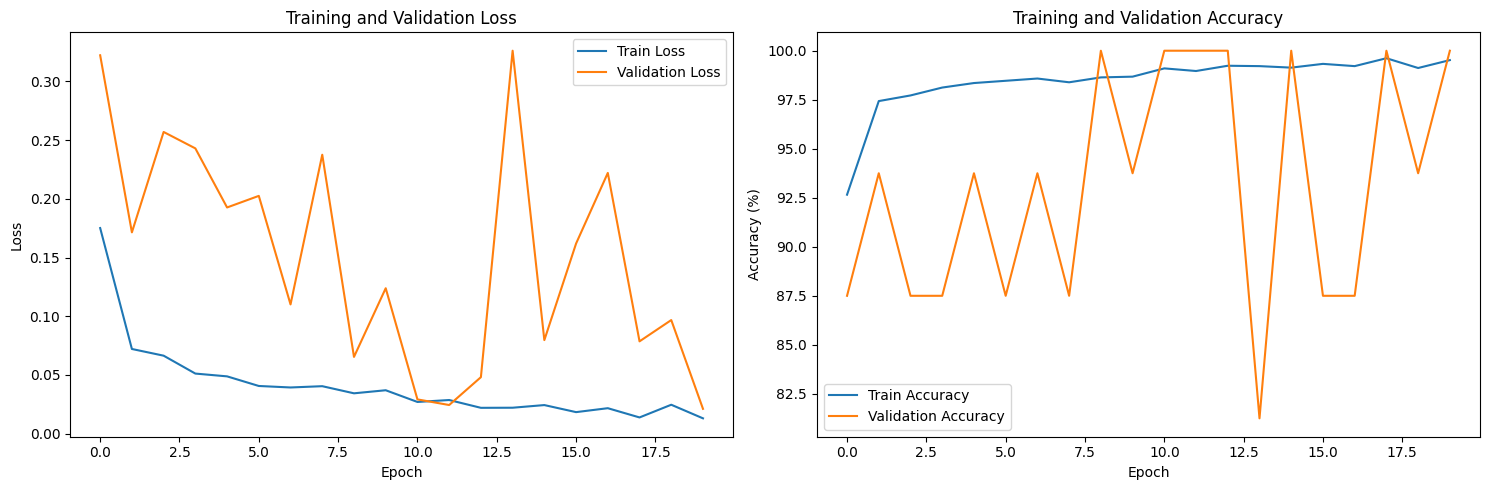

In [47]:
plot_loss_acc(metrics_densenet)

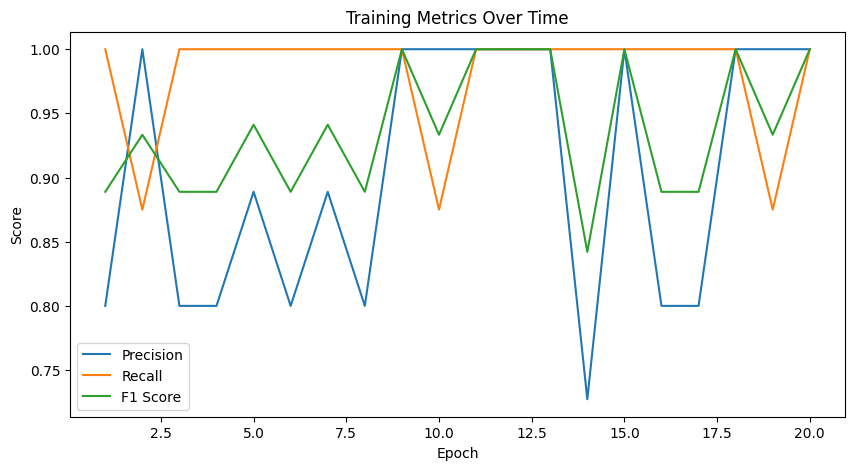

In [48]:
plot_other_metrics(metrics_densenet)


Evaluating best model...


<ipython-input-41-4ac8f29d7a0b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.49it


Test Set Evaluation Results:
Test Loss: 0.1910
Test Accuracy: 95.35%
Precision: 0.9547
Recall: 0.9718
F1 Score: 0.9632
ROC AUC: 0.9878
Average Precision: 0.9911


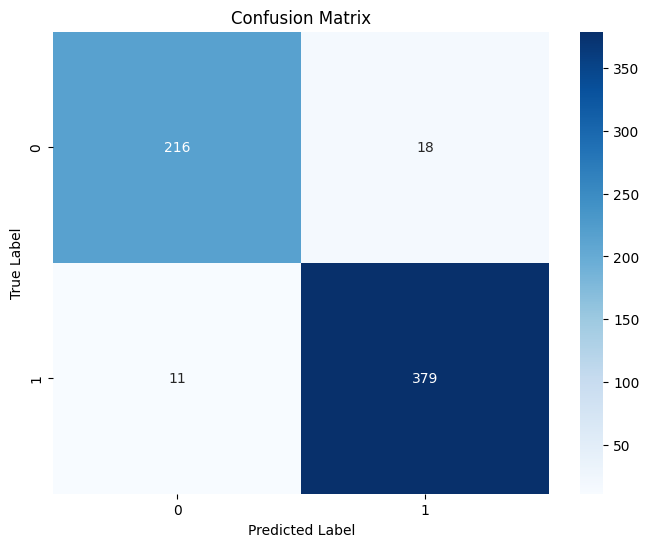

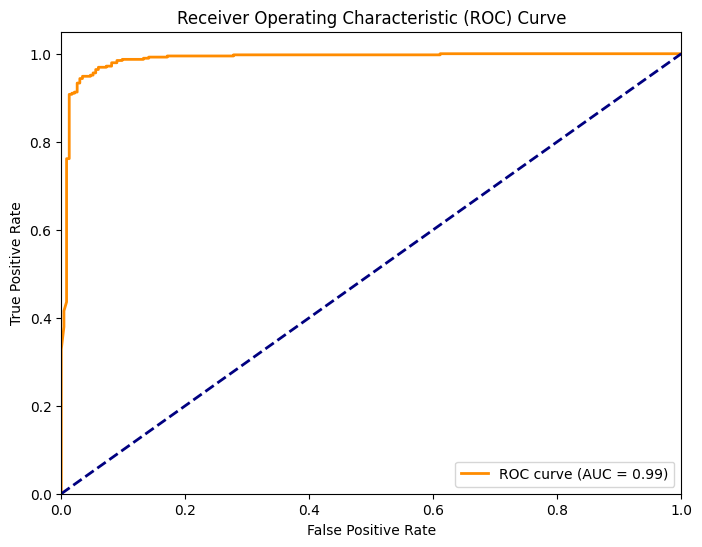

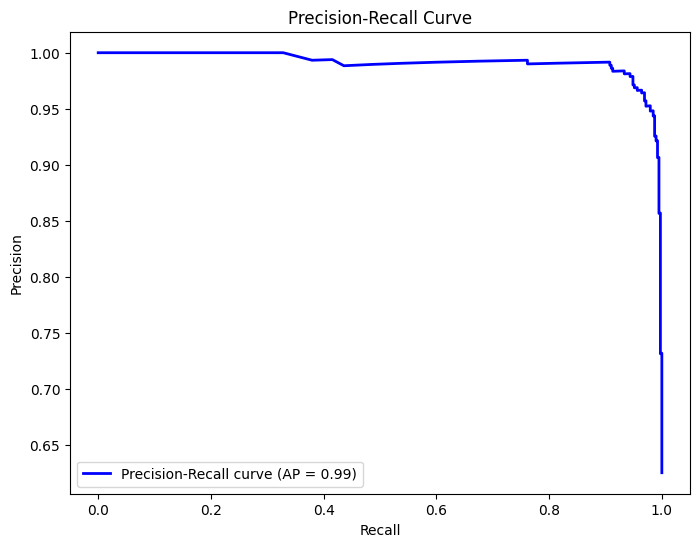

<Figure size 1500x500 with 0 Axes>

In [49]:
# Example usage:
print("\nEvaluating best model...")
eval_metrics_densenet = evaluate_trained_model(
    model_path='best_model.pth',
    model=densenet_model,
    test_loader=test_loader,
    device=DEVICE,
    writer=writer
)

In [50]:
# Access specific metrics if needed
print("\nTest Performance Summary:")
print(f"Final Test Accuracy: {eval_metrics_densenet['test_accuracy']:.2f}%")
print(f"ROC AUC Score: {eval_metrics_densenet['roc_auc']:.4f}")
print(f"Average Precision Score: {eval_metrics_densenet['average_precision']:.4f}")


Test Performance Summary:
Final Test Accuracy: 95.35%
ROC AUC Score: 0.9878
Average Precision Score: 0.9911


## Finetuning DenseNet

In [51]:
from torch.optim import lr_scheduler  # Add this import
import copy


In [52]:
def finetune_densenet(model, train_loader, val_loader, num_epochs=25, device='cuda'):
    """
    Finetuning function for DenseNet with gradual unfreezing
    """
    writer = SummaryWriter('runs/densenet_finetuning')
    criterion = nn.BCELoss()
    
    # First train only the classifier
    for param in model.densenet.features.parameters():
        param.requires_grad = False
        
    # Optimizer for first phase (only classifier)
    optimizer_phase1 = optim.Adam(model.densenet.classifier.parameters(), lr=0.001)
    scheduler_phase1 = lr_scheduler.ReduceLROnPlateau(optimizer_phase1, mode='min', 
                                                    factor=0.1, patience=3)
    
    print("Phase 1: Training classifier layers only...")
    model, metrics_phase1 = train_phase(model, criterion, optimizer_phase1, scheduler_phase1,
                                      train_loader, val_loader, num_epochs//2, device, 
                                      writer, 'phase1')
    
    # Unfreeze all layers for fine-tuning
    for param in model.densenet.features.parameters():
        param.requires_grad = True
        
    # Optimizer for second phase (all layers)
    optimizer_phase2 = optim.Adam([
        {'params': model.densenet.features.parameters(), 'lr': 0.0001},
        {'params': model.densenet.classifier.parameters(), 'lr': 0.001}
    ])
    scheduler_phase2 = lr_scheduler.ReduceLROnPlateau(optimizer_phase2, mode='min', 
                                                    factor=0.1, patience=3)
    
    print("\nPhase 2: Fine-tuning all layers...")
    model, metrics_phase2 = train_phase(model, criterion, optimizer_phase2, scheduler_phase2,
                                      train_loader, val_loader, num_epochs//2, device, 
                                      writer, 'phase2')
    
    # Combine metrics from both phases
    combined_metrics = {
        'phase1': metrics_phase1,
        'phase2': metrics_phase2,
        'final_performance': {
            'phase1_best_val_acc': metrics_phase1['best_val_acc'],
            'phase2_best_val_acc': metrics_phase2['best_val_acc'],
            'overall_best_val_acc': max(metrics_phase1['best_val_acc'], 
                                      metrics_phase2['best_val_acc'])
        }
    }
    
    writer.close()
    return model, combined_metrics

In [53]:
def train_phase(model, criterion, optimizer, scheduler, train_loader, val_loader, 
                num_epochs, device, writer, phase_name):
    """
    Training function for each phase with comprehensive metric tracking
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Initialize metrics dictionary
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'learning_rates': [],
        'per_epoch_stats': [],
        'best_epoch': 0,
        'best_val_acc': 0.0,
        'best_val_loss': float('inf')
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        epoch_stats = {'epoch': epoch + 1}
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_predictions = []
        train_labels_list = []
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                preds = (outputs > 0.5).float()
                
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            
            # Store predictions and labels for metrics
            train_predictions.extend(preds.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Calculate training metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        train_precision = precision_score(train_labels_list, train_predictions, zero_division=0)
        train_recall = recall_score(train_labels_list, train_predictions, zero_division=0)
        train_f1 = f1_score(train_labels_list, train_predictions, zero_division=0)
        
        # Store training metrics
        metrics['train_losses'].append(epoch_loss)
        metrics['train_accuracies'].append(epoch_acc.item())
        current_lr = optimizer.param_groups[0]['lr']
        metrics['learning_rates'].append(current_lr)
        
        epoch_stats.update({
            'train_loss': epoch_loss,
            'train_accuracy': epoch_acc.item(),
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'learning_rate': current_lr
        })
        
        writer.add_scalar(f'Loss/train_{phase_name}', epoch_loss, epoch)
        writer.add_scalar(f'Accuracy/train_{phase_name}', epoch_acc, epoch)
        writer.add_scalar(f'Metrics/train_precision_{phase_name}', train_precision, epoch)
        writer.add_scalar(f'Metrics/train_recall_{phase_name}', train_recall, epoch)
        writer.add_scalar(f'Metrics/train_f1_{phase_name}', train_f1, epoch)
        writer.add_scalar(f'Learning_rate_{phase_name}', current_lr, epoch)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Train Precision: {train_precision:.4f} Recall: {train_recall:.4f} F1: {train_f1:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        val_predictions = []
        val_labels_list = []
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            with torch.no_grad():
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                preds = (outputs > 0.5).float()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            
            # Store predictions and labels for metrics
            val_predictions.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        # Calculate validation metrics
        val_precision = precision_score(val_labels_list, val_predictions, zero_division=0)
        val_recall = recall_score(val_labels_list, val_predictions, zero_division=0)
        val_f1 = f1_score(val_labels_list, val_predictions, zero_division=0)
        
        # Store validation metrics
        metrics['val_losses'].append(epoch_loss)
        metrics['val_accuracies'].append(epoch_acc.item())
        
        epoch_stats.update({
            'val_loss': epoch_loss,
            'val_accuracy': epoch_acc.item(),
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1
        })
        
        metrics['per_epoch_stats'].append(epoch_stats)
        
        writer.add_scalar(f'Loss/val_{phase_name}', epoch_loss, epoch)
        writer.add_scalar(f'Accuracy/val_{phase_name}', epoch_acc, epoch)
        writer.add_scalar(f'Metrics/val_precision_{phase_name}', val_precision, epoch)
        writer.add_scalar(f'Metrics/val_recall_{phase_name}', val_recall, epoch)
        writer.add_scalar(f'Metrics/val_f1_{phase_name}', val_f1, epoch)
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}')
        
        # Update learning rate
        scheduler.step(epoch_loss)
        
        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            metrics['best_epoch'] = epoch + 1
            metrics['best_val_acc'] = epoch_acc.item()
            metrics['best_val_loss'] = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # Save model and metrics
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': epoch_acc,
                'val_loss': epoch_loss,
                'metrics': metrics
            }, f'best_model_{phase_name}.pth')
        
        print()
    
    print(f'Best val Acc: {best_acc:4f}')
    
    # Add final summary metrics
    metrics['final_stats'] = {
        'final_train_loss': metrics['train_losses'][-1],
        'final_train_accuracy': metrics['train_accuracies'][-1],
        'final_val_loss': metrics['val_losses'][-1],
        'final_val_accuracy': metrics['val_accuracies'][-1],
        'best_epoch': metrics['best_epoch'],
        'best_val_acc': metrics['best_val_acc'],
        'best_val_loss': metrics['best_val_loss']
    }
    
    # Save final metrics to JSON
    import json
    with open(f'training_metrics_{phase_name}.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    
    model.load_state_dict(best_model_wts)
    return model, metrics


In [54]:
print("Finetuning DenseNet...")
densenet_model,densenet_finemetrics = finetune_densenet(densenet_model, train_loader, val_loader, 
                                     num_epochs=20, device=DEVICE)

Finetuning DenseNet...
Phase 1: Training classifier layers only...
Epoch 0/9
----------
Train Loss: 0.0139 Acc: 0.9956
Train Precision: 0.9977 Recall: 0.9964 F1: 0.9970
Val Loss: 0.0053 Acc: 1.0000
Val Precision: 1.0000 Recall: 1.0000 F1: 1.0000

Epoch 1/9
----------
Train Loss: 0.0118 Acc: 0.9960
Train Precision: 0.9977 Recall: 0.9969 F1: 0.9973
Val Loss: 0.0017 Acc: 1.0000
Val Precision: 1.0000 Recall: 1.0000 F1: 1.0000

Epoch 2/9
----------
Train Loss: 0.0088 Acc: 0.9973
Train Precision: 0.9982 Recall: 0.9982 F1: 0.9982
Val Loss: 0.0156 Acc: 1.0000
Val Precision: 1.0000 Recall: 1.0000 F1: 1.0000

Epoch 3/9
----------
Train Loss: 0.0099 Acc: 0.9964
Train Precision: 0.9972 Recall: 0.9979 F1: 0.9975
Val Loss: 0.0033 Acc: 1.0000
Val Precision: 1.0000 Recall: 1.0000 F1: 1.0000

Epoch 4/9
----------
Train Loss: 0.0120 Acc: 0.9958
Train Precision: 0.9974 Recall: 0.9969 F1: 0.9972
Val Loss: 0.0069 Acc: 1.0000
Val Precision: 1.0000 Recall: 1.0000 F1: 1.0000

Epoch 5/9
----------
Train Loss: 


Evaluating best model...


<ipython-input-41-4ac8f29d7a0b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.70it


Test Set Evaluation Results:
Test Loss: 0.1910
Test Accuracy: 95.35%
Precision: 0.9547
Recall: 0.9718
F1 Score: 0.9632
ROC AUC: 0.9878
Average Precision: 0.9911


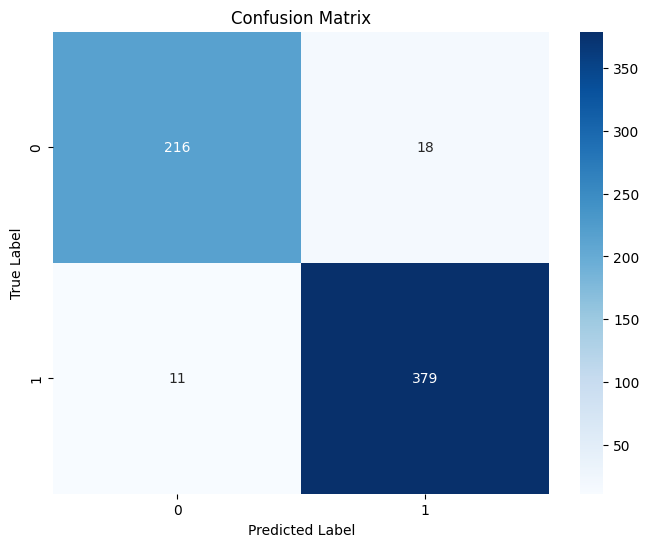

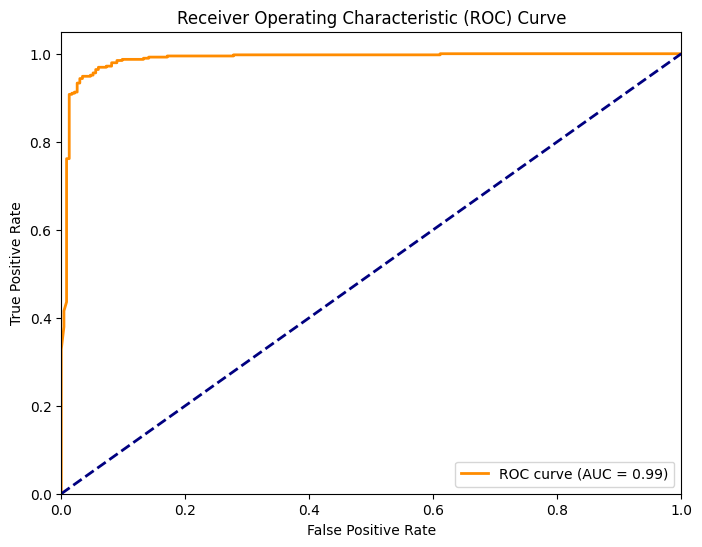

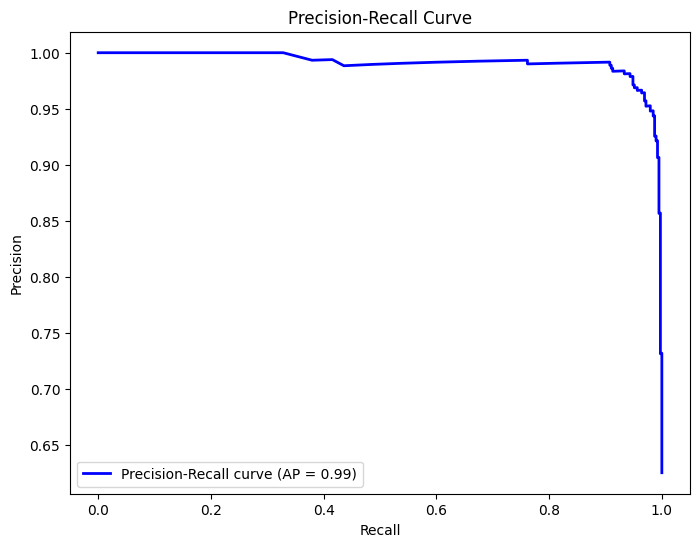

<Figure size 1500x500 with 0 Axes>

In [55]:
# Example usage:
print("\nEvaluating best model...")
eval_metrics_densenet = evaluate_trained_model(
    model_path='best_model.pth',
    model=densenet_model,
    test_loader=test_loader,
    device=DEVICE,
    writer=writer
)

In [56]:
# Access specific metrics if needed
print("\nTest Performance Summary:")
print(f"Final Test Accuracy: {eval_metrics_densenet['test_accuracy']:.2f}%")
print(f"ROC AUC Score: {eval_metrics_densenet['roc_auc']:.4f}")
print(f"Average Precision Score: {eval_metrics_densenet['average_precision']:.4f}")


Test Performance Summary:
Final Test Accuracy: 95.35%
ROC AUC Score: 0.9878
Average Precision Score: 0.9911


## Model 3 - EfficientNet

In [57]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetModel, self).__init__()
        # Load pretrained EfficientNet-B0
        self.effnet = models.efficientnet_b0(pretrained=True)
        
        # Modify classifier
        num_ftrs = self.effnet.classifier[1].in_features
        self.effnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.effnet(x)

In [58]:
effnet_model = EfficientNetModel().to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
writer = SummaryWriter('runs/efficientnet_training')
criterion = nn.BCELoss()

# Use different learning rates for pretrained layers and new layers
optimizer = optim.Adam([
    {'params': effnet_model.effnet.features.parameters(), 'lr': 0.0001},
    {'params': effnet_model.effnet.classifier.parameters(), 'lr': 0.001}
])


print("Training Efficient Net model...")
metrics_densenet = train_model(effnet_model, train_loader, 
                                        val_loader, criterion, optimizer, 
                                        20, writer)

Training Efficient Net model...


Epoch 1/20: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]


Epoch 1/20:
Train Loss: 0.1535, Train Acc: 93.52%
Val Loss: 0.0540, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 2/20: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]


Epoch 2/20:
Train Loss: 0.0839, Train Acc: 96.82%
Val Loss: 0.1341, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412


Epoch 3/20: 100%|██████████| 163/163 [00:45<00:00,  3.57it/s]


Epoch 3/20:
Train Loss: 0.0622, Train Acc: 97.49%
Val Loss: 0.0330, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 4/20: 100%|██████████| 163/163 [00:46<00:00,  3.54it/s]


Epoch 4/20:
Train Loss: 0.0650, Train Acc: 97.45%
Val Loss: 0.1030, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 5/20: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]


Epoch 5/20:
Train Loss: 0.0505, Train Acc: 98.20%
Val Loss: 0.4858, Val Acc: 75.00%
Precision: 0.6667, Recall: 1.0000, F1: 0.8000


Epoch 6/20: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]


Epoch 6/20:
Train Loss: 0.0465, Train Acc: 98.27%
Val Loss: 0.1456, Val Acc: 93.75%
Precision: 1.0000, Recall: 0.8750, F1: 0.9333


Epoch 7/20: 100%|██████████| 163/163 [00:45<00:00,  3.55it/s]


Epoch 7/20:
Train Loss: 0.0451, Train Acc: 98.39%
Val Loss: 0.1298, Val Acc: 93.75%
Precision: 1.0000, Recall: 0.8750, F1: 0.9333


Epoch 8/20: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]


Epoch 8/20:
Train Loss: 0.0346, Train Acc: 98.60%
Val Loss: 0.0557, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 9/20: 100%|██████████| 163/163 [00:46<00:00,  3.53it/s]


Epoch 9/20:
Train Loss: 0.0314, Train Acc: 98.96%
Val Loss: 0.0646, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 10/20: 100%|██████████| 163/163 [00:45<00:00,  3.57it/s]


Epoch 10/20:
Train Loss: 0.0395, Train Acc: 98.54%
Val Loss: 0.0608, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 11/20: 100%|██████████| 163/163 [00:46<00:00,  3.47it/s]


Epoch 11/20:
Train Loss: 0.0294, Train Acc: 99.02%
Val Loss: 0.0495, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 12/20: 100%|██████████| 163/163 [00:45<00:00,  3.59it/s]


Epoch 12/20:
Train Loss: 0.0268, Train Acc: 98.96%
Val Loss: 0.0171, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 13/20: 100%|██████████| 163/163 [00:45<00:00,  3.58it/s]


Epoch 13/20:
Train Loss: 0.0261, Train Acc: 99.02%
Val Loss: 0.0650, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 14/20: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]


Epoch 14/20:
Train Loss: 0.0239, Train Acc: 99.29%
Val Loss: 0.0328, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 15/20: 100%|██████████| 163/163 [00:45<00:00,  3.57it/s]


Epoch 15/20:
Train Loss: 0.0178, Train Acc: 99.29%
Val Loss: 0.0755, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 16/20: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]


Epoch 16/20:
Train Loss: 0.0180, Train Acc: 99.33%
Val Loss: 0.0050, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 17/20: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]


Epoch 17/20:
Train Loss: 0.0251, Train Acc: 99.08%
Val Loss: 0.0658, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 18/20: 100%|██████████| 163/163 [00:46<00:00,  3.48it/s]


Epoch 18/20:
Train Loss: 0.0203, Train Acc: 99.35%
Val Loss: 0.0534, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 19/20: 100%|██████████| 163/163 [00:46<00:00,  3.53it/s]


Epoch 19/20:
Train Loss: 0.0164, Train Acc: 99.50%
Val Loss: 0.0703, Val Acc: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 20/20: 100%|██████████| 163/163 [00:46<00:00,  3.47it/s]


Epoch 20/20:
Train Loss: 0.0172, Train Acc: 99.44%
Val Loss: 0.0671, Val Acc: 93.75%
Precision: 0.8889, Recall: 1.0000, F1: 0.9412



Evaluating best model...


<ipython-input-41-4ac8f29d7a0b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.96it


Test Set Evaluation Results:
Test Loss: 0.5422
Test Accuracy: 93.59%
Precision: 0.9227
Recall: 0.9795
F1 Score: 0.9502
ROC AUC: 0.9836
Average Precision: 0.9873


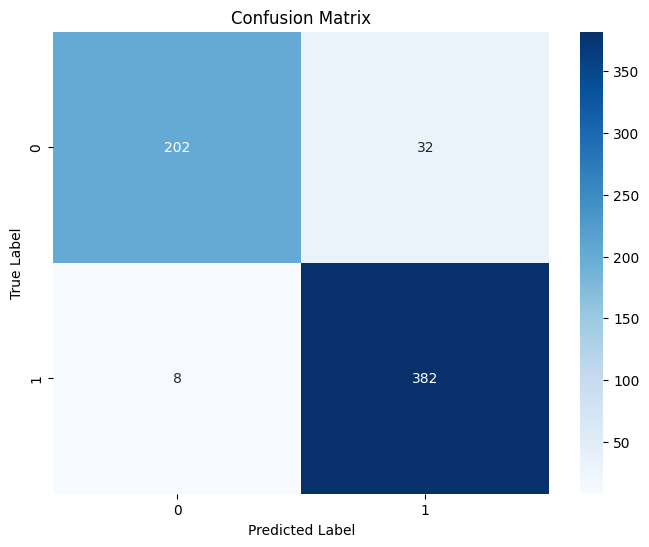

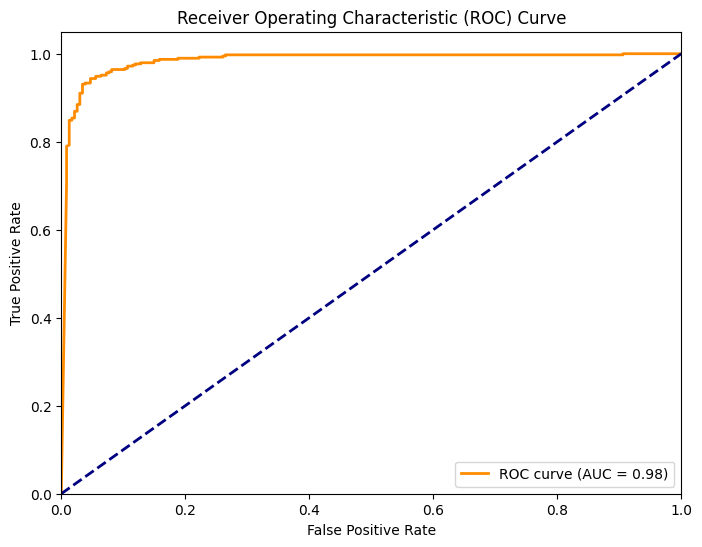

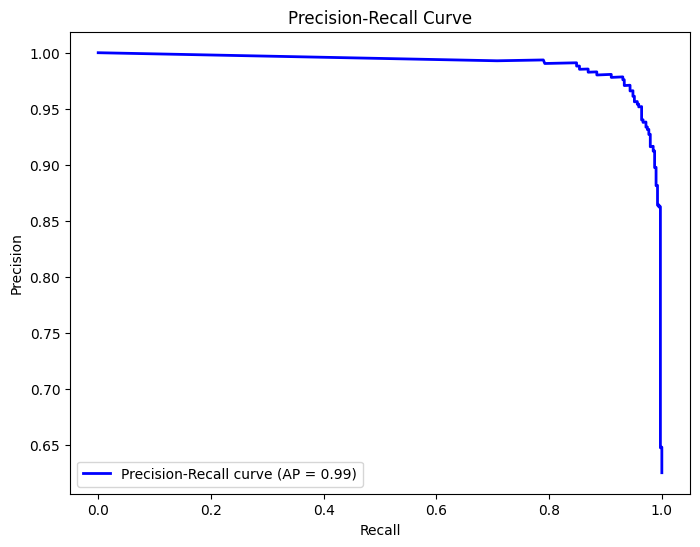

<Figure size 1500x500 with 0 Axes>

In [60]:
# Example usage:
print("\nEvaluating best model...")
eval_metrics_effnet = evaluate_trained_model(
    model_path='best_model.pth',
    model=effnet_model,
    test_loader=test_loader,
    device=DEVICE,
    writer=writer
)

In [61]:
# Access specific metrics if needed
print("\nTest Performance Summary:")
print(f"Final Test Accuracy: {eval_metrics_effnet['test_accuracy']:.2f}%")
print(f"ROC AUC Score: {eval_metrics_effnet['roc_auc']:.4f}")
print(f"Average Precision Score: {eval_metrics_effnet['average_precision']:.4f}")


Test Performance Summary:
Final Test Accuracy: 93.59%
ROC AUC Score: 0.9836
Average Precision Score: 0.9873


## Comparing the models performance

1. DenseNet (both base and finetuned) outperforms ResNet across all metrics
2. The finetuned DenseNet shows better performance to the base DenseNet, showing the importance of fine tuning on DenseNet.
3. DenseNet 
- Higher recall in DenseNet (0.9718 vs 0.9564) indicates better detection of positive pneumonia cases
- Improved precision (0.9547 vs 0.9348) shows fewer false positives
4. ResNet, while performing well, lags behind in all metrics but still achieves clinically useful results
5. DenseNet model (either base or finetuned) would be the preferred choice for pneumonia detection as it:
- Has the highest accuracy (95.35%)
- Shows better balance between precision and recall
- Demonstrates superior ROC AUC and average precision scores
- Provides better clinical utility with higher recall for detecting positive cases

## Attention of your model

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
import os

class GradCAM:
    def __init__(self, model):
        self.model = model
        # For DenseNet, we want to use the last dense block
        self.target_layer = model.densenet.features.denseblock4
        self.gradients = None
        self.activations = None
        
        def forward_hook(module, input, output):
            self.activations = output
            
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(self, input_tensor):
        """Generate class activation map."""
        # Forward pass
        model_output = self.model(input_tensor)
        
        # Backward pass
        self.model.zero_grad()
        model_output.backward()
        
        # Generate CAM
        with torch.no_grad():
            # Global average pooling of gradients
            weights = torch.mean(self.gradients, dim=(2, 3))[0, :]
            
            # Weight the channels by corresponding gradients
            cam = torch.zeros(self.activations.shape[2:], device=self.activations.device)
            for i, w in enumerate(weights):
                cam += w * self.activations[0, i, :, :]
            
            # Apply ReLU to focus on features that have a positive influence
            cam = F.relu(cam)
            
            # Normalize
            if cam.max() != 0:
                cam = cam / cam.max()
            
            # Convert to numpy for visualization
            cam = cam.cpu().numpy()
            
        return cam


In [34]:
def visualize_model_attention(model, test_loader, device, num_images=5, save_dir='attention_maps'):
    """Generate attention visualizations for multiple images and display in notebook."""
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize GradCAM
    grad_cam = GradCAM(model)
    model.eval()
    
    # Process images
    processed = 0
    all_figures = []
    
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        if processed >= num_images:
            break
            
        for i in range(min(inputs.size(0), num_images - processed)):
            print(f"\nProcessing image {processed + 1}/{num_images}")
            
            # Get single image
            input_tensor = inputs[i:i+1].to(device)
            label = labels[i].item()
            class_name = "PNEUMONIA" if label == 1 else "NORMAL"
            
            # Generate class activation map
            model.zero_grad()
            cam = grad_cam.generate_cam(input_tensor)
            
            # Convert input tensor to numpy image
            input_image = inputs[i].cpu().numpy().transpose(1, 2, 0)
            input_image = np.clip(input_image * np.array([0.229, 0.224, 0.225]) + 
                                np.array([0.485, 0.456, 0.406]), 0, 1)
            
            # Resize CAM to match input size
            cam_resized = cv2.resize(cam, (input_image.shape[1], input_image.shape[0]))
            
            # Create heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            heatmap = heatmap[..., ::-1]  # BGR to RGB
            
            # Combine original image and heatmap
            alpha = 0.5
            superimposed = alpha * heatmap + (1-alpha) * input_image
            superimposed = np.clip(superimposed, 0, 1)
            
            # Create and display figure
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))
            fig.suptitle(f'Class: {class_name}', fontsize=16, y=1.05)
            
            # Plot original image
            axes[0].imshow(input_image, cmap='gray' if input_image.shape[-1] == 1 else None)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            # Plot attention map
            attention_plot = axes[1].imshow(cam_resized, cmap='jet')
            axes[1].set_title('Attention Map')
            axes[1].axis('off')
            plt.colorbar(attention_plot, ax=axes[1], fraction=0.046, pad=0.04)
            
            # Plot superimposed image
            axes[2].imshow(superimposed)
            axes[2].set_title('Attention Overlay')
            axes[2].axis('off')
            
            plt.tight_layout()
            
            # Save figure
            save_path = os.path.join(save_dir, f'attention_map_{processed}.png')
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            # Display in notebook
            plt.show()
            
            all_figures.append(fig)
            
            processed += 1
            if processed >= num_images:
                break
    
    return all_figures

def visualize_attention_maps(model, test_loader, device):
    print("Generating attention maps...")
    model = model.to(device)
    model.eval()
    
    figures = visualize_model_attention(
        model=model,
        test_loader=test_loader,
        device=device,
        num_images=5,
        save_dir='attention_maps'
    )
    
    print("\nAttention maps have been generated and saved in 'attention_maps' directory")
    return figures

Generating attention maps...

Processing image 1/5


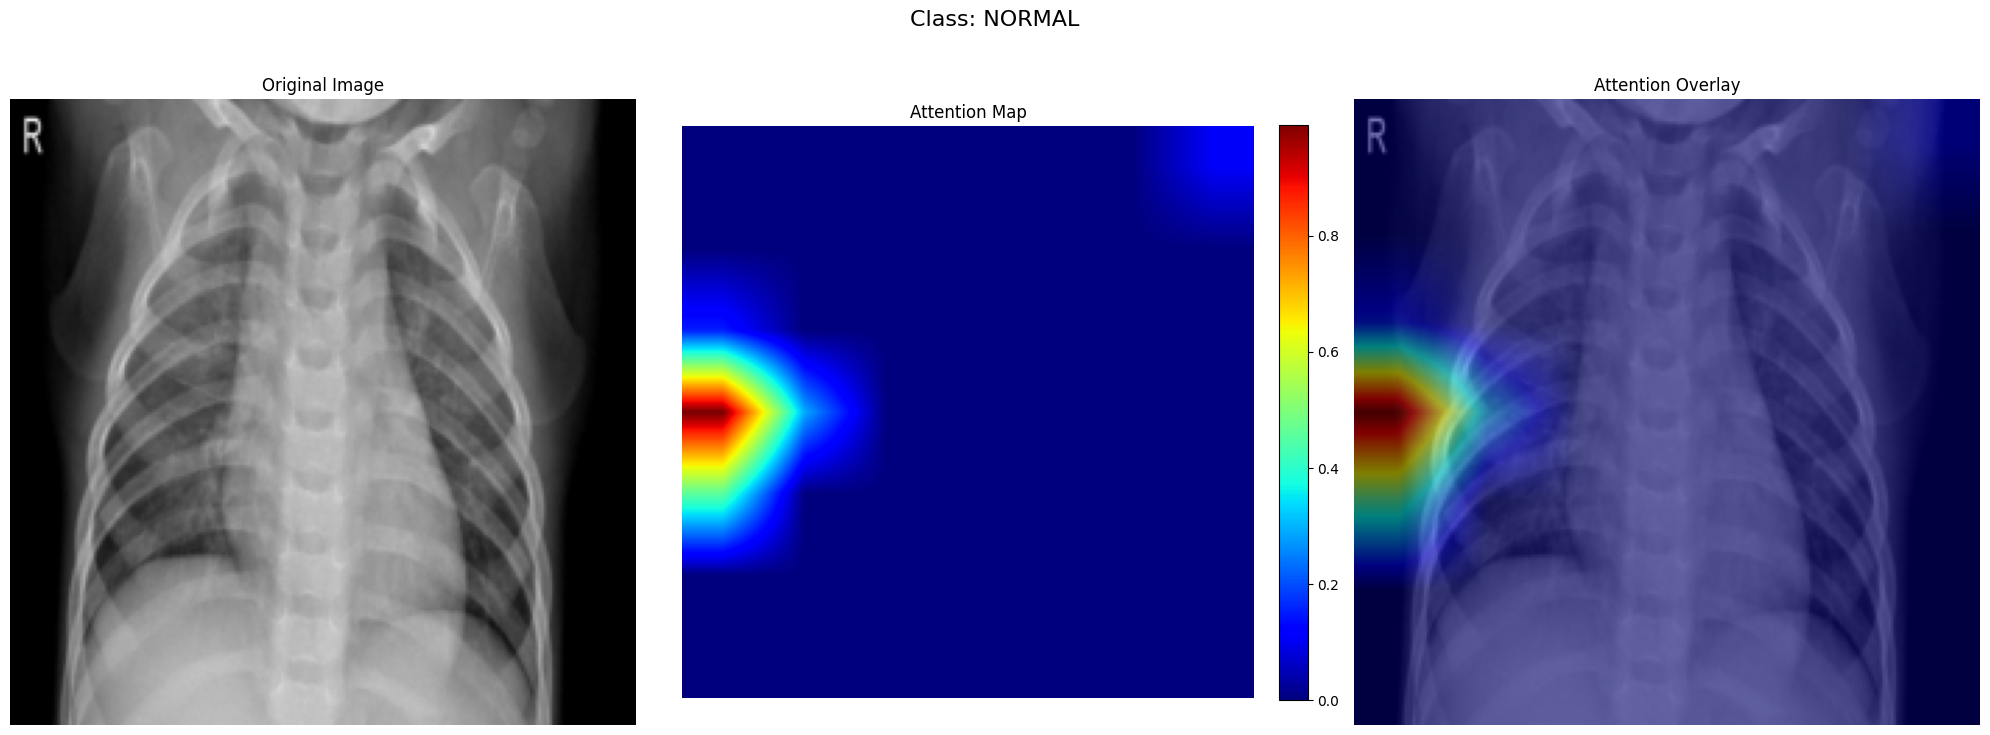


Processing image 2/5


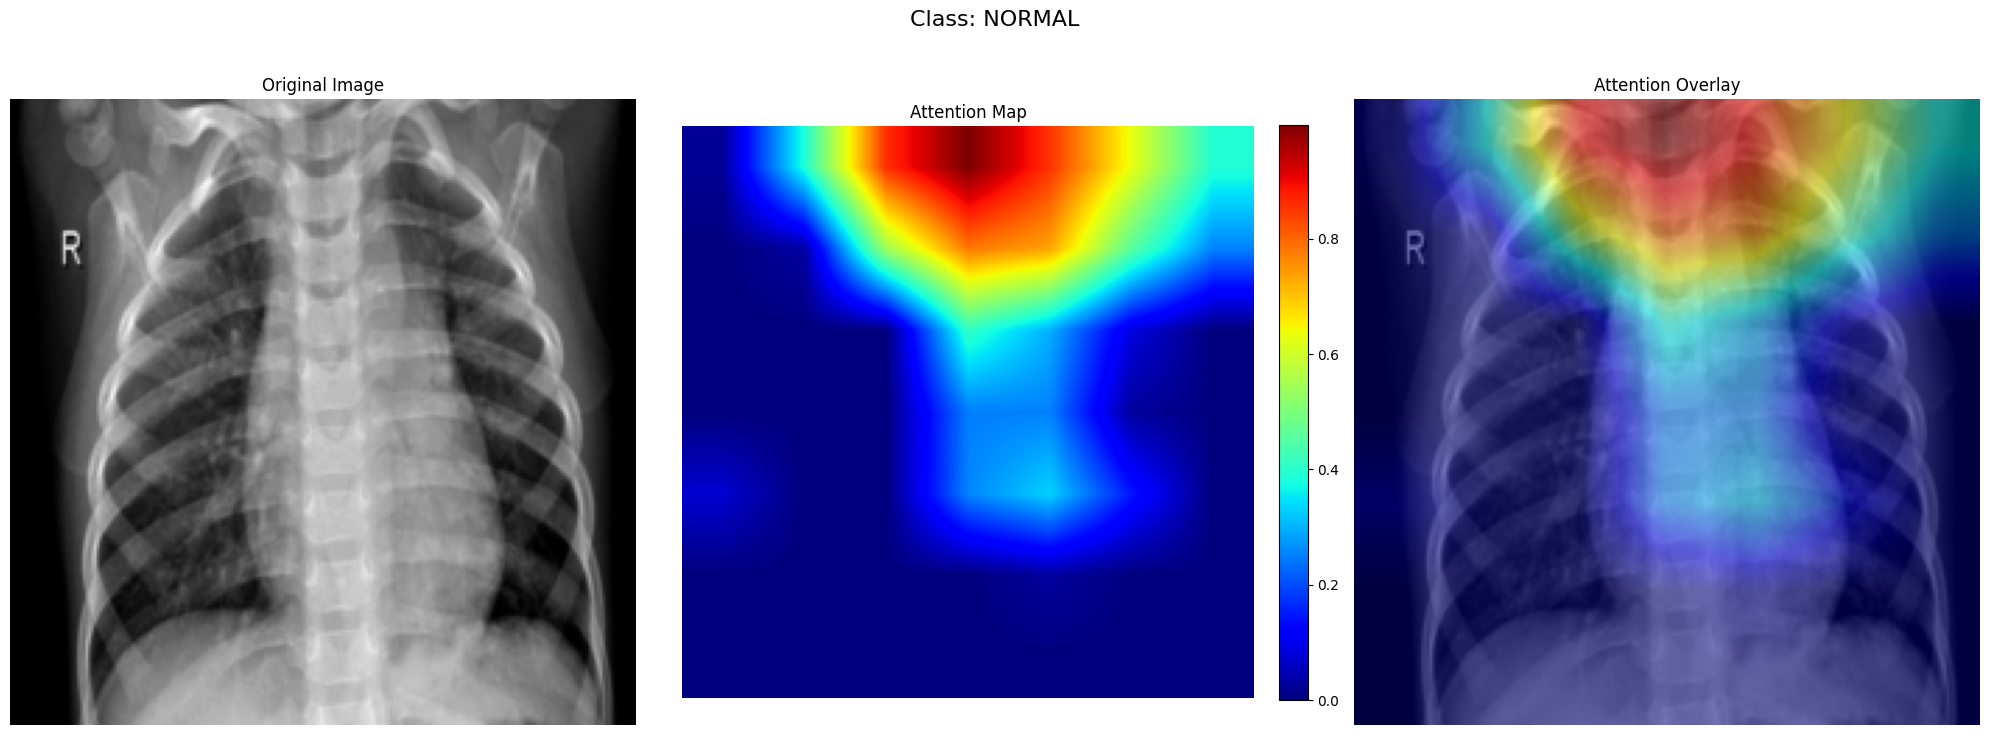


Processing image 3/5


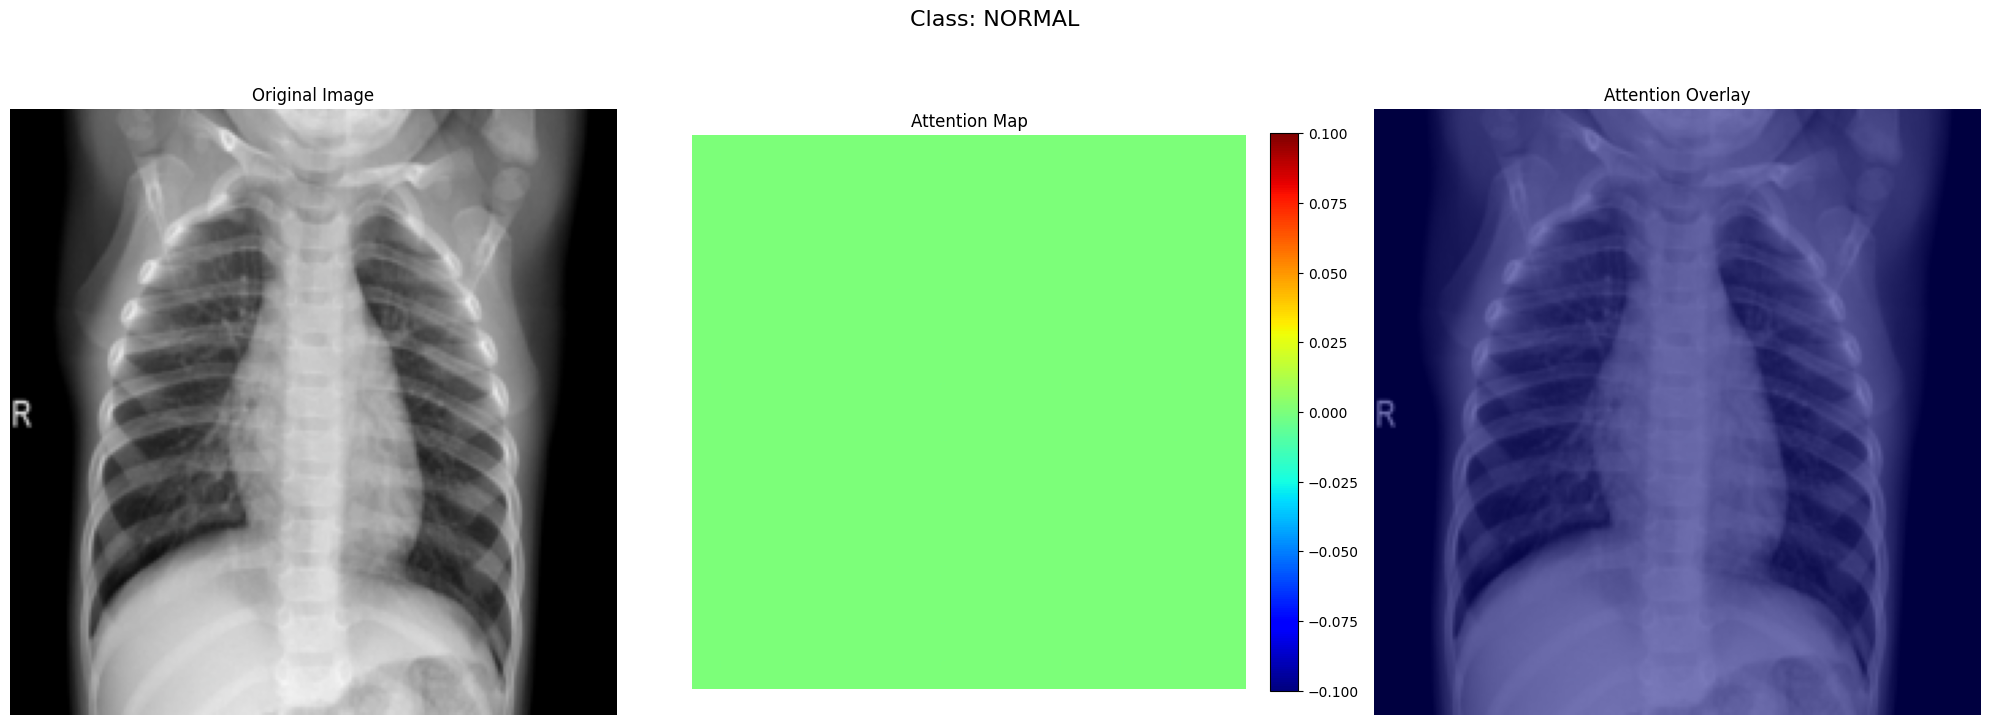


Processing image 4/5


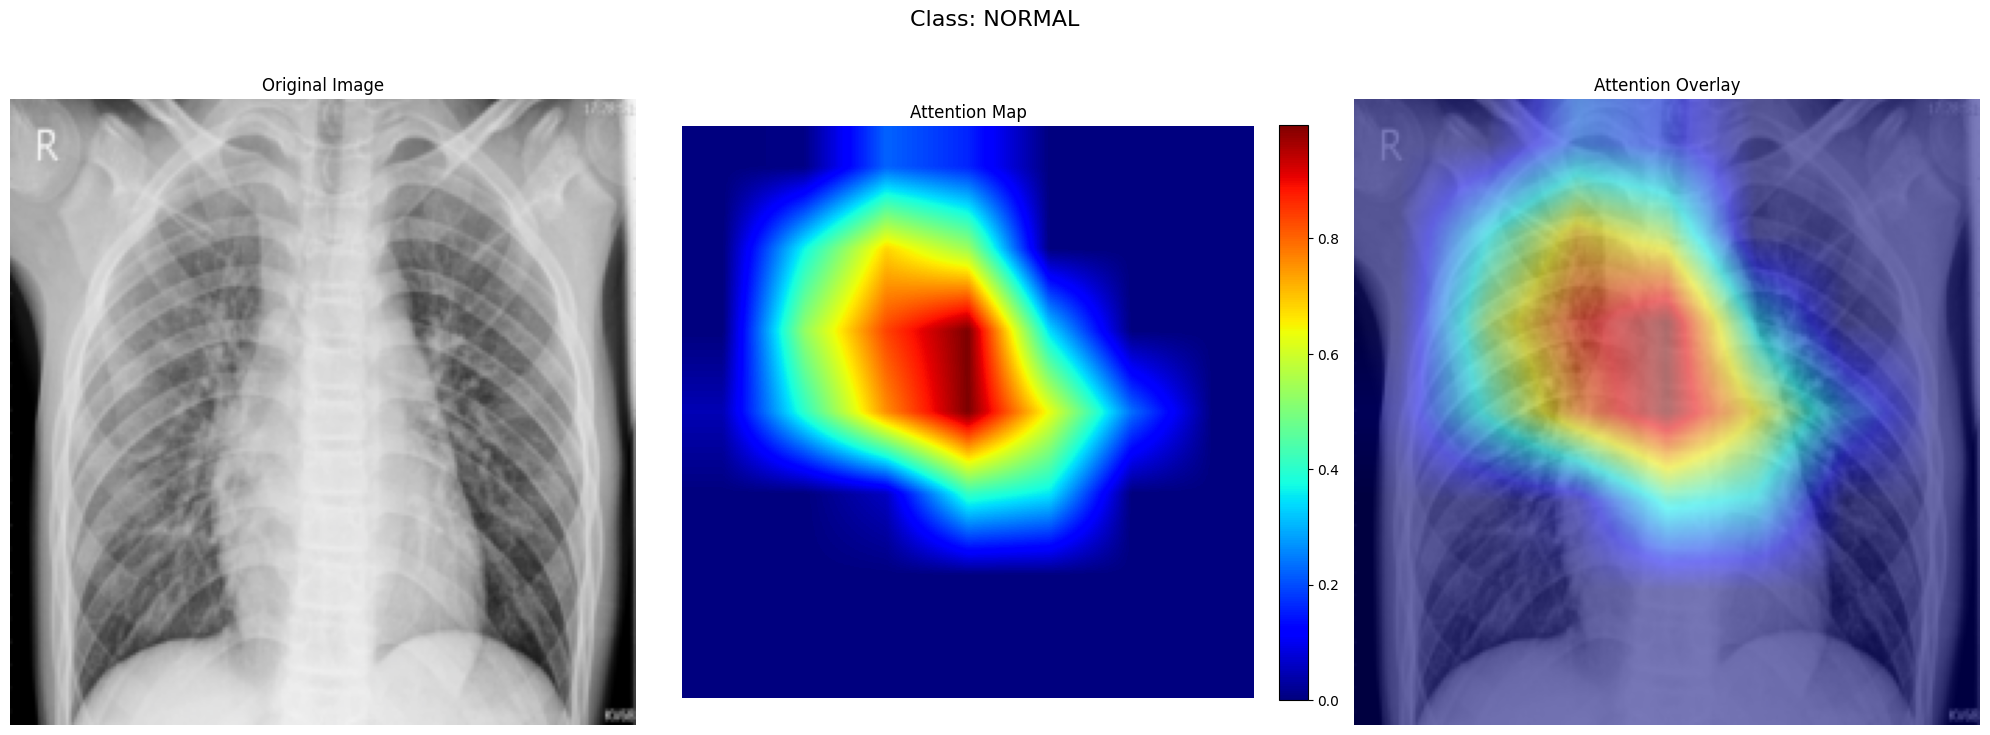


Processing image 5/5


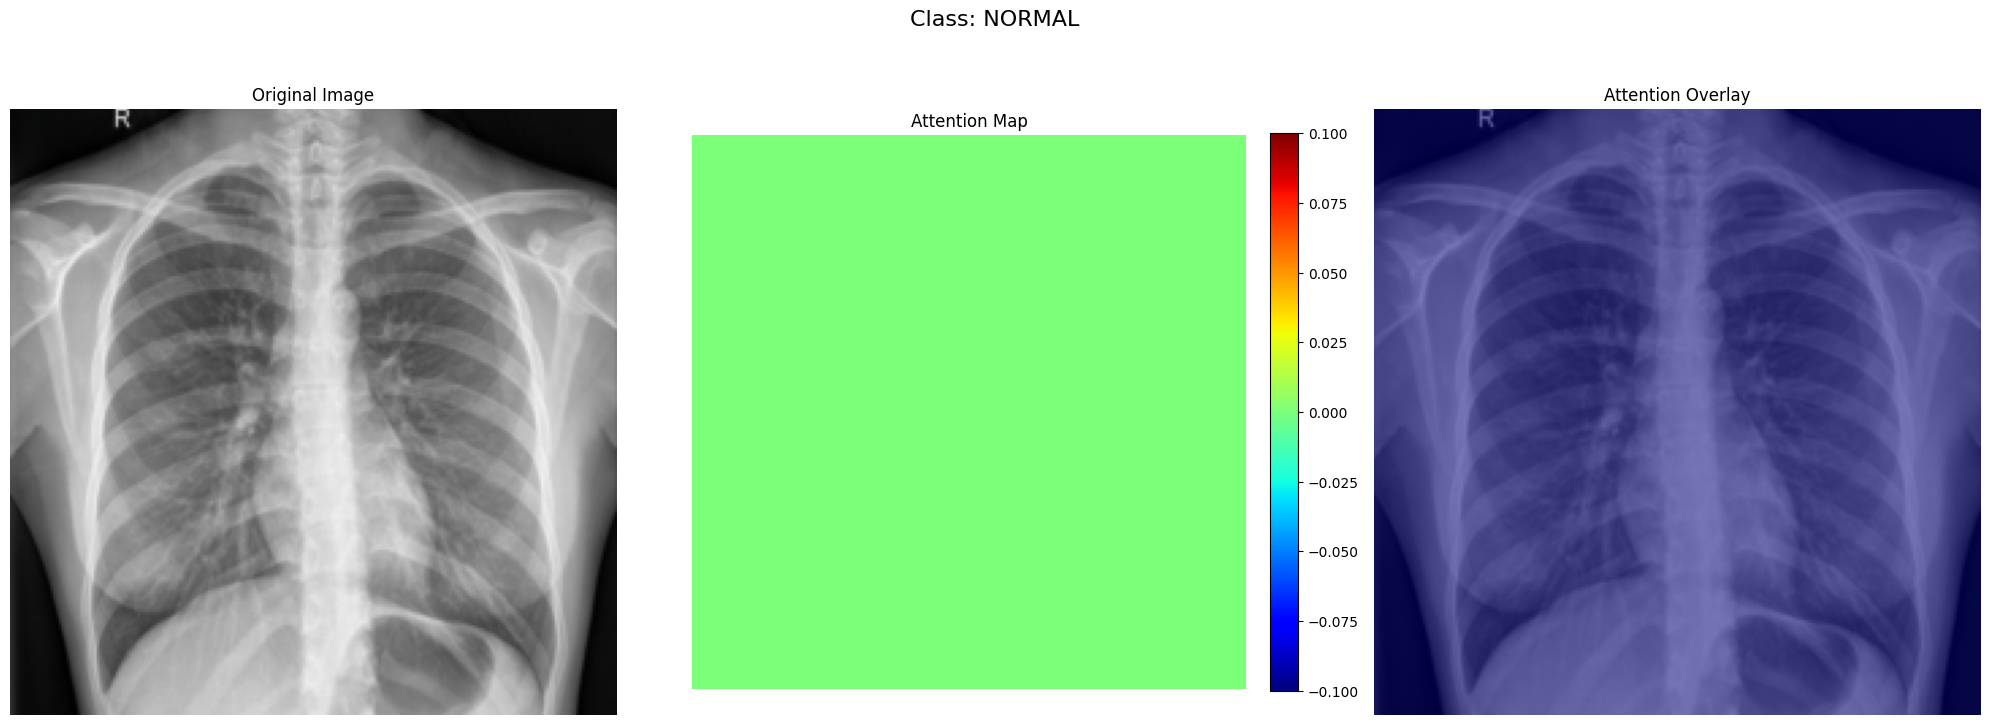


Attention maps have been generated and saved in 'attention_maps' directory


In [35]:
attention_figures = visualize_attention_maps(densenet_model, test_loader, DEVICE)

## Setting up Tensorboard

In [36]:
from tensorboard import notebook
notebook.start("--logdir /kaggle/working/runs")

<IPython.core.display.Javascript object>

In [4]:
!pip install kaggle

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105797 sha256=32d8a70ac206085c179571d440caec756a4dd255272b3d988f063a9eb720ecfb
  Stored in directory: c:\users\rishita\appdata\local\pip\cache\wheels\ff\55\fb\b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Rishita\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
!kaggle kernels output rishita26/"DA312-Lab-6" -p ./kaggle/working/runs

Output file downloaded to ./kaggle/working/runs\best_model.pth
Output file downloaded to ./kaggle/working/runs\evaluation_metrics.json
Output file downloaded to ./kaggle/working/runs\runs/efficientnet_training/events.out.tfevents.1739436056.d0bbb6b157db.31.0
Output file downloaded to ./kaggle/working/runs\runs/efficientnet_training/events.out.tfevents.1739436078.d0bbb6b157db.31.1
Output file downloaded to ./kaggle/working/runs\training_metrics.json
Kernel log downloaded to ./kaggle/working/runs\DA312-Lab-6.log 


In [8]:
!kaggle kernels output rishita26/"DA312-Lab-6" -p ./kaggle/working/runs/pneumonia_experiment

Output file downloaded to ./kaggle/working/runs/pneumonia_experiment\best_model.pth
Output file downloaded to ./kaggle/working/runs/pneumonia_experiment\evaluation_metrics.json
Output file downloaded to ./kaggle/working/runs/pneumonia_experiment\runs/efficientnet_training/events.out.tfevents.1739436056.d0bbb6b157db.31.0
Output file downloaded to ./kaggle/working/runs/pneumonia_experiment\runs/efficientnet_training/events.out.tfevents.1739436078.d0bbb6b157db.31.1
Output file downloaded to ./kaggle/working/runs/pneumonia_experiment\training_metrics.json
Kernel log downloaded to ./kaggle/working/runs/pneumonia_experiment\DA312-Lab-6.log 


In [ ]:
# Initialize TensorBoard
#%load_ext tensorboard
%tensorboard --logdir r"C:\Users\Rishita\Desktop\kaggle\runs\efficientnet_training" --port=6010


In [31]:
def tensorboard_additional_features(model, writer, data_loader):
    """
    Demonstrate additional TensorBoard features
    """
    # 1. Model graph
    sample_input = next(iter(data_loader))[0][:1].to(DEVICE)
    writer.add_graph(model, sample_input)
    
    # 2. Parameter histograms
    for name, param in model.named_parameters():
        writer.add_histogram(f'Parameters/{name}', param.data.cpu().numpy(), 0)
        if param.grad is not None:
            writer.add_histogram(f'Gradients/{name}', param.grad.cpu().numpy(), 0)
    
    # 3. PR Curves
    model.eval()
    predictions = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            predictions.extend(probs)
            labels.extend(targets.numpy())
    
    writer.add_pr_curve('PR Curve', 
                       np.array(labels), 
                       np.array(predictions), 
                       global_step=0)
    
    # 4. Custom scalars
    layout = {
        "Model Performance": {
            "Accuracy": ["Multiline", ["Accuracy/train", "Accuracy/val"]],
     "Loss": ["Multiline", ["Loss/train", "Loss/val"]]
        }
    }
    writer.add_custom_scalars(layout)